## New York City Dog Bite Data Study.

We have a dataset containing historical data on dog bites reported in New York City from 2015-2022.

The data are provided by the New York City Department of Health and Mental Hygiene (DOHMH). Data is collected from reports received online, mail, fax or by phone to 311 or NYC DOHMH Animal Bite Unit. Each record represents a single dog bite incident. Information on breed, age, gender and Spayed or Neutered status have not been verified by DOHMH and is listed only as reported to DOHMH. A blank space in the dataset means no data was available.


**Study Objective**
* Identify areas of the city where the problem of dog attacks is most acute
* Test the hypothesis that seasonality affects the number of bites
* Identify aggressive breeds

**Data Description**

* `UniqueID` — unique case number
* `DateOfBite` — case date
* `Species` — animal specie
* `Breed` — breed
* `Age` — age
* `Gender` — sex
* `SpayNeuter` — spay or neuter status
* `Borough` — <a href="https://en.wikipedia.org/wiki/Boroughs_of_New_York_City">Borough (district) New York</a>
* `ZipCode` — ZIP code

**Research plan**

We obtained the data from a file provided by the DOHMH Animal Bite Unit. The quality of the data is not yet known.
Therefore, before conducting the exploratory analysis and testing the hypotheses, we will need a review of the data.

The study will be conducted in several stages:

1 — Data Review\
2 — Data Preprocessing\
3 — Exploratory Analysis\
4 — General Conclusion


### Loading and examination of data


In [1]:
#importing Python libraries
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
import seaborn as sns
import warnings
from IPython.display import display_html 

In [2]:
warnings.filterwarnings('ignore')#disable warnings about changes in libraries
sns.set_palette("Set2")#setting colors for the seaborn library
data = pd.read_csv('DOHMH_Dog_Bite_Data.csv')#save data into variable

Let's display the first 5 rows of the table and apply the info() method

In [3]:
display(data.head())
data.info()

,UniqueID,DateOfBite,Species,Breed,Age,Gender,SpayNeuter,Borough,ZipCode
0,1,January 01 2018,DOG,UNKNOWN,NaN,U,False,Brooklyn,11220
1,2,January 04 2018,DOG,UNKNOWN,NaN,U,False,Brooklyn,NaN
2,3,January 06 2018,DOG,Pit Bull,NaN,U,False,Brooklyn,11224
3,4,January 08 2018,DOG,Mixed/Other,4,M,False,Brooklyn,11231
4,5,January 09 2018,DOG,Pit Bull,NaN,U,False,Brooklyn,11224


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26127 entries, 0 to 26126
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   UniqueID    26127 non-null  int64 
 1   DateOfBite  26127 non-null  object
 2   Species     26127 non-null  object
 3   Breed       23864 non-null  object
 4   Age         12868 non-null  object
 5   Gender      26127 non-null  object
 6   SpayNeuter  26127 non-null  bool  
 7   Borough     26127 non-null  object
 8   ZipCode     18960 non-null  object
dtypes: bool(1), int64(1), object(7)
memory usage: 1.6+ MB


#### Interim conclusion

* Some columns, such as `UniqueID` and `Species`, `ZipCode` are not needed for the study. We can remove them from the dataframe
* There is a lot of missing data in the columns `Breed`, `Age`, `ZipCode`
* Column names have uppercase letters, it's better to convert all the names to snake case
* `DateOfBite` column type should be changed. We will change the object type to datetime64
* Data should be checked for exact and partial duplicates

Below, we will remove unnecessary columns, clarify the presence of duplicates in the rows, correct the column names and data types, and work with missing data.

### Data preprocessing

#### Finding and removing duplicate records
First, let's check the dataset for exact duplicate rows:

In [4]:
display(data.duplicated().sum())

0

There are no such rows, now let's move on to searching for partial duplicates that may be found in the string columns `borough`, `gender` and `breed`.
Let's start with the `Borough` column

In [5]:
display(data['Borough'].value_counts())#counting unique values in a column

Borough
Queens           6693
Manhattan        6081
Brooklyn         5698
Bronx            4375
Staten Island    2140
Other            1140
Name: count, dtype: int64

1140 rows with the value `Other`. Since there are only 5 boroughs in New York City, we can assume that this category includes cases that either occurred outside the city or the location was unknown. Either way, let's filter these rows out to leave only information with known boroughs. Otherwise, the borough names are spelled correctly.

In [6]:
data = data.query('Borough != "Other"')#remove lines with Borough = Other

Now let's check the `Gender` column

In [7]:
data['Gender'].unique().tolist()#list unique values of 'Gender' column

['U', 'M', 'F']

There are only three values in the column. There are no partial duplicates.

Now let's check the `Breed` column

In [8]:
len(data['Breed'].unique())#count unique values of 'Gender' column

1702

In total, the dataset contains 1702 unique breed names

Let's see which of them are most common:

In [9]:
data['Breed'].value_counts().head(10)#list top 10 by frequency unique values of 'Gender' column 

Breed
Pit Bull                                4450
UNKNOWN                                 3217
Shih Tzu                                 768
Chihuahua                                711
German Shepherd                          681
American Pit Bull Mix / Pit Bull Mix     551
Mixed/Other                              530
Yorkshire Terrier                        524
American Pit Bull Terrier/Pit Bull       521
MIXED                                    485
Name: count, dtype: int64

In [10]:
data['Breed'].value_counts().tail(10)#list last 10 by frequency unique values of 'Gender' column

Breed
LABRADOR/SHAR-PEI MIX         1
RAT TERRIER / SHIH TZU MIX    1
HOUND / LAB MIX               1
DOBERMAN AND LABRADOR         1
MALTESE / WESTIE MIX          1
PITBULL BOXER MIX             1
ROTTWEILER/HUSKY MIX          1
MALTI-POO                     1
JACK RUSSELL/MALTESE MIX      1
SHIH TZU / POMERANIAN         1
Name: count, dtype: int64

**Observations**

The column contains raw data.

* Breed names are written in different ways (for example, `American Pit Bull Mix / Pit Bull Mix` and `American Pit Bull Terrier/Pit Bull`), with typos and in different cases
* The second most common value is `UNKNOWN` (English "unknown"), also in the top 20 there is `MIXED`, which means any crossbreed.

For now, we will leave this column as is and come back to it later.

#### Removing unnecessary columns

The following columns are not needed for the study:

`UniqueID` — duplicates the internal numbering in the dataframe\
`Species` — the data is about dog bites only, so the species is always `DOG`\
`ZipCode` — we are only interested in the distribution by districts (boroughs)\
`Age` — this column has data missing (only 12 868 of 26 127 rows are filled). Also, given that the data for this column is a rough estimate, it is difficult to use this data for any conclusions.

In [11]:
#removing extra columns
data = data.drop(columns=['UniqueID','Species','ZipCode','Age'])

#### Converting column names to snake case

In [12]:
data.columns = data.columns.str.lower()
data = data.rename(columns={'dateofbite': 'date_of_bite','spayneuter': 'spay_or_neuter'})

Look at just the first 5 rows

In [13]:
data.head()

,date_of_bite,breed,gender,spay_or_neuter,borough
0,January 01 2018,UNKNOWN,U,False,Brooklyn
1,January 04 2018,UNKNOWN,U,False,Brooklyn
2,January 06 2018,Pit Bull,U,False,Brooklyn
3,January 08 2018,Mixed/Other,M,False,Brooklyn
4,January 09 2018,Pit Bull,U,False,Brooklyn


#### Changing data types and adding new columns

* Change the `date_of_bite` column type to datetime64

Add several columns based on the `date_of_bite` column:
* `month_of_bite` — month name as an abbreviation
* `month_of_bite_number` — month of the case as a number
* `year_of_bite` — year of the case

In [14]:
#data type conversion
data['date_of_bite'] = pd.to_datetime(data['date_of_bite'])

In [15]:
#adding new columns
data['month_of_bite'] = data['date_of_bite'].dt.strftime('%b')
data['month_of_bite_number'] = pd.DatetimeIndex(data['date_of_bite']).month 
data['year_of_bite'] = pd.DatetimeIndex(data['date_of_bite']).year 

data.head()

,date_of_bite,breed,gender,spay_or_neuter,borough,month_of_bite,month_of_bite_number,year_of_bite
0,2018-01-01,UNKNOWN,U,False,Brooklyn,Jan,1,2018
1,2018-01-04,UNKNOWN,U,False,Brooklyn,Jan,1,2018
2,2018-01-06,Pit Bull,U,False,Brooklyn,Jan,1,2018
3,2018-01-08,Mixed/Other,M,False,Brooklyn,Jan,1,2018
4,2018-01-09,Pit Bull,U,False,Brooklyn,Jan,1,2018


#### Filling in missing values

In [16]:
data.info()#applying info() method to the updated table

<class 'pandas.core.frame.DataFrame'>
Index: 24987 entries, 0 to 26126
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date_of_bite          24987 non-null  datetime64[ns]
 1   breed                 22861 non-null  object        
 2   gender                24987 non-null  object        
 3   spay_or_neuter        24987 non-null  bool          
 4   borough               24987 non-null  object        
 5   month_of_bite         24987 non-null  object        
 6   month_of_bite_number  24987 non-null  int32         
 7   year_of_bite          24987 non-null  int32         
dtypes: bool(1), datetime64[ns](1), int32(2), object(4)
memory usage: 1.4+ MB


There is only one column left in the dataset that contains gaps — `breed`.
Above, we found out that one of the most frequent values ​​in the column is `UNKNOWN`, which in this case is a synonym for missing data.
Let's replace all the gaps in the column with `UNKNOWN`.

In [17]:
#filling missing values with UNKNOWN
data['breed'] = data['breed'].fillna(value='UNKNOWN')
#counting missing values
data['breed'].isna().sum()

0

#### Interim conclusion
We prepared the data for work:

* removed unnecessary columns
* changed the column names to snake case
* checked the dataset for missing values and filled the gaps with suitable values
* checked the dataset for exact and partial duplicates, found that `breed` column contains raw data
* changed the data type in the `date_of_bite` column to a suitable one and added additional columns with the month and year of the case based on it.

### Seasonality Analysis

Let's check the time period that the dataset covers:

In [18]:
print ('Earliest date in the dataset:',data['date_of_bite'].min())
print ('Latest date in the dataset:',data['date_of_bite'].max())

Earliest date in the dataset: 2015-01-01 00:00:00
Latest date in the dataset: 2022-12-31 00:00:00


As stated in the data description, the dataset covers 8 years. From January 1, 2015 to December 31, 2022.

Let's group the cases by year and month:

In [19]:
#creating a pivot table with grouping by years
bites_per_year = data.groupby('year_of_bite')['date_of_bite'].count().to_frame().reset_index()
bites_per_year.columns = ['year_of_bite','total']

#creating a pivot table with grouping by months
bites_per_month = data.pivot_table(index=['month_of_bite_number','month_of_bite'],
                                          values='date_of_bite',
                                          aggfunc=['count']).droplevel('month_of_bite_number', axis=0)
#rename the column and reset the index
bites_per_month.columns = ['total']
bites_per_month = bites_per_month.reset_index()

#look at both tables
df1_styler = bites_per_year.style.set_table_attributes("style='display:inline'").set_caption('<b>Distribution of dog bite cases by year</b>')
df2_styler = bites_per_month.style.set_table_attributes("style='display:inline'").set_caption('<b>Distribution of dog bite cases by month</b>')
display_html(df1_styler._repr_html_()+15*'&nbsp' +df2_styler._repr_html_(), raw=True)

,year_of_bite,total
0,2015,3390
1,2016,3085
2,2017,3368
3,2018,3238
4,2019,3389
5,2020,2424
6,2021,2788
7,2022,3305
,month_of_bite,total
0,Jan,1613


In [20]:
#counting the average number of events in the summer
summer_months = bites_per_month.sort_values(by='total',ascending=False)['total'][:3]
summer_months_mean = summer_months.sum()/3

#counting the average number of events in the winter
winter_months = bites_per_month.sort_values(by='total',ascending=False)['total'][-3:]
winter_months_mean = winter_months.sum()/3

#calculating the difference between the number of cases in summer and winter as a percentage 
print('difference between the number of cases in summer and winter —',
      "{0:.2f}%".format(100 - round(winter_months_mean/summer_months_mean*100,2)))

difference between the number of cases in summer and winter — 34.50%


**Visualizing pivot tables on a graph**

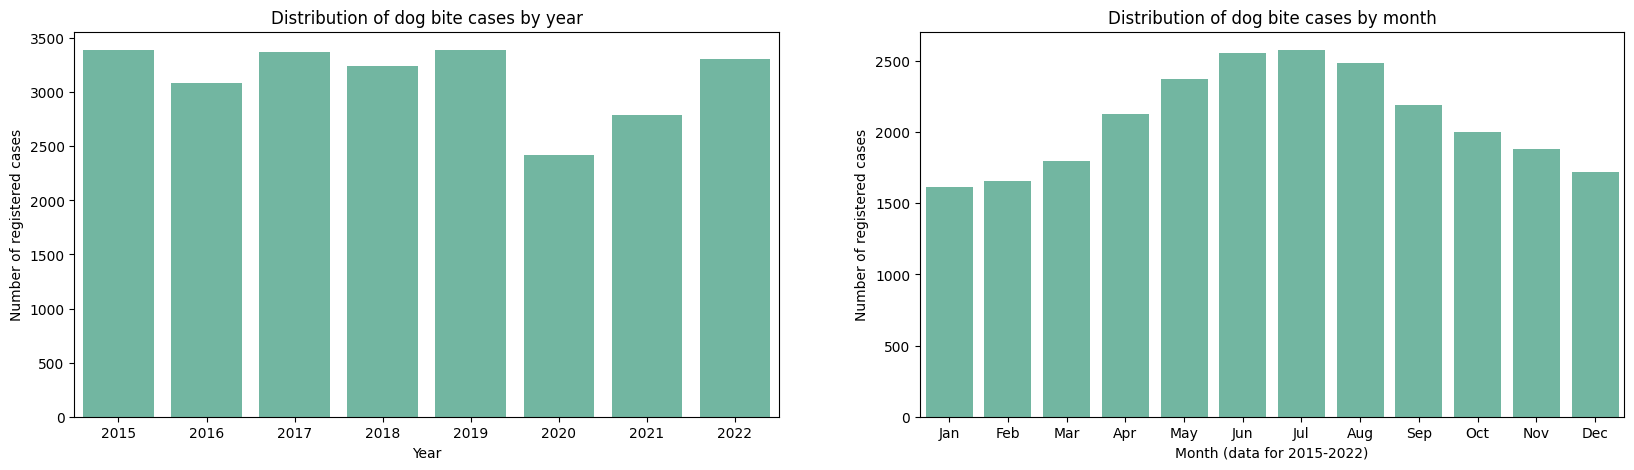

In [21]:
#creating plots
fig, axes= plt.subplots(1, 2)
fig.set_size_inches(20, 5)

sns.barplot(ax=axes[0],data=bites_per_year, x='year_of_bite', y='total', errorbar=None)
axes[0].set_title('Distribution of dog bite cases by year')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Number of registered cases')

sns.barplot(ax=axes[1],data=bites_per_month, x='month_of_bite', y='total', errorbar=None)
axes[1].set_title('Distribution of dog bite cases by month')
axes[1].set_xlabel('Month (data for 2015-2022)')
axes[1].set_ylabel('Number of registered cases');

#### Interim conclusion

* The least number of cases were recorded in 2020 and 2021. This may be due to the coronavirus pandemic and the period of self-isolation rules in the city. These are the only years during the study period in which fewer than 3,000 cases were observed.
* The most number of cases were recorded in 2015 (3 390 cases)
* There is a pronounced seasonality of events: in the winter months, on average, 34.5% fewer cases were recorded than in the summer

### Distribution of cases by borough

There are five major governmental districts (boroughs) in New York:

1. `Manhattan`
2. `Brooklyn`
3. `Queens` 
4. `Bronx`
5. `Staten Island`

Let's create a pivot table with grouping by districts and months:

In [22]:
#creating a pivot table with grouping by months and boroughs
monthly_bites_by_borough = data.pivot_table(index=['month_of_bite_number','month_of_bite'],
                        columns='borough',
                                          values='date_of_bite',
                                          aggfunc=['count'])

monthly_bites_by_borough.columns = monthly_bites_by_borough.columns.droplevel()
monthly_bites_by_borough.index = monthly_bites_by_borough.index.droplevel()
monthly_bites_by_borough

borough,Bronx,Brooklyn,Manhattan,Queens,Staten Island
month_of_bite,,,,,
Jan,322,353,419,370,149
Feb,297,370,440,415,138
Mar,345,378,443,469,160
Apr,357,500,521,560,189
May,405,527,609,625,206
Jun,392,626,578,751,209
Jul,448,613,534,751,232
Aug,398,586,599,708,195
Sep,378,519,527,588,183


Let's visualize the resulting table on a heat map

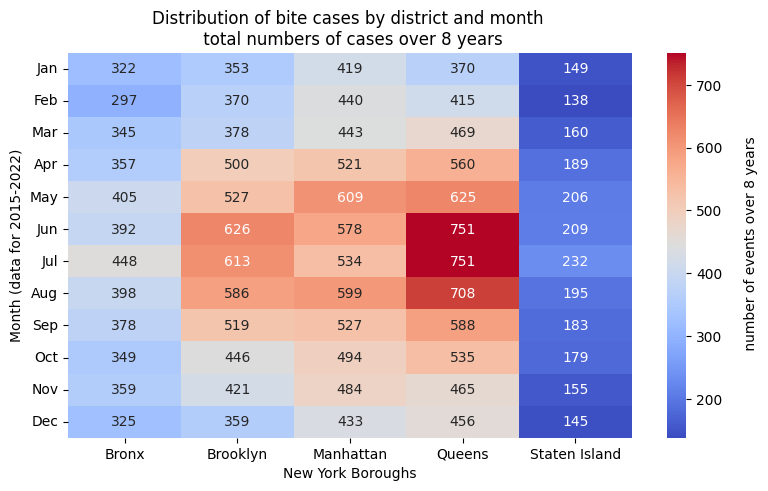

In [23]:
#creating heatmap
plt.figure(figsize=(20, 5))

sns.heatmap(
    monthly_bites_by_borough, ax=plt.subplot(1, 2, 1), cmap="coolwarm", annot=True, fmt='.0f',cbar_kws={'label': '\n number of events over 8 years'}
)
plt.yticks(rotation=0)

#assigning axes and titles
plt.title('Distribution of bite cases by district and month \n total numbers of cases over 8 years')
plt.xlabel('New York Boroughs') 
plt.ylabel('Month (data for 2015-2022)');

**Observations:**

* The seasonality of cases, which we noted above, is clearly visible
* The least number of events occur in the Staten Island borough, the most number of cases occur in Queens

Could we assume from this that Queens is the most dangerous in terms of bites, and Staten Island is the safest? We did not take into account the population of the boroughs in our calculations.
Next, we will calculate the number of bites per borough resident.

----

The <a href="https://en.wikipedia.org/wiki/Demographics_of_New_York_City#cite_note-41:~:text=New%20York%20City%27s%20five%20boroughs">Wikipedia page</a> contains data on the latest US census in 2020. Let's take the data from this source and save it into a variable:

In [24]:
#creating a dictionary with census data  (millions of residents)
population = {
  "Bronx": 1.472654,
  "Brooklyn": 2.736074,
  "Manhattan": 1.694251,
   "Queens": 2.405464,
  "Staten Island": 0.495747 
}
population

{'Bronx': 1.472654,
 'Brooklyn': 2.736074,
 'Manhattan': 1.694251,
 'Queens': 2.405464,
 'Staten Island': 0.495747}

In [25]:
#creating a copy of the dataset monthly_bites_by_borough
bites_per_population = monthly_bites_by_borough.copy()

#dividing the values in dataset by the corresponding number of millions of residents, rounding to 2 decimal places
for i in bites_per_population:
    bites_per_population[i] = round(bites_per_population[i]/population[i],2)

bites_per_population

borough,Bronx,Brooklyn,Manhattan,Queens,Staten Island
month_of_bite,,,,,
Jan,218.65,129.02,247.31,153.82,300.56
Feb,201.68,135.23,259.70,172.52,278.37
Mar,234.27,138.15,261.47,194.97,322.75
Apr,242.42,182.74,307.51,232.80,381.24
May,275.01,192.61,359.45,259.83,415.53
Jun,266.19,228.79,341.15,312.21,421.59
Jul,304.21,224.04,315.18,312.21,467.98
Aug,270.26,214.18,353.55,294.33,393.35
Sep,256.68,189.69,311.05,244.44,369.14


**Visualizing new table on a heat map:**

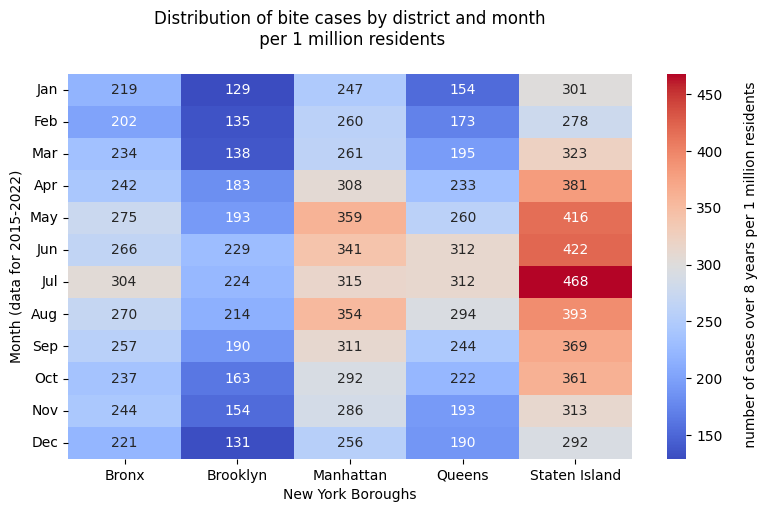

In [26]:
#creating heatmap
plt.figure(figsize=(20, 5))

sns.heatmap(
    bites_per_population, ax=plt.subplot(1, 2, 1),  cmap="coolwarm", annot=True, fmt='.0f',cbar_kws={'label': '\n number of cases over 8 years per 1 million residents'}
)

plt.yticks(rotation=0)

#assigning axes and titles
plt.title('Distribution of bite cases by district and month\n per 1 million residents\n')
plt.xlabel('New York Boroughs') 
plt.ylabel('Month (data for 2015-2022)');

Let's find out how many bites are registered on average per year in the leading borough of Staten Island.

In [27]:
#divide the sum of the 'Staten Island' column by 8 years
bites_per_population['Staten Island'].sum()/8

539.59125

**Observations:**

The situation has changed. Since Staten Island has the smallest population, the borough has become the first in terms of events per resident (540 per 1 million people per year)

#### Interim conclusion

* The largest number of events per capita occur in Staten Island
* Fewest number of events per capita occur in Brooklyn

### Identifying aggressive breeds

Information about the dog breed is contained in the `breed` column. We found out that this column contains raw data, lets try to correct it at least partially in order to understand the main trends.

In [28]:
print('Number of unique breeds before data cleaning —', len(data['breed'].unique().tolist()))

Number of unique breeds before data cleaning — 1701


In [29]:
#converting all names to lowercase
data['breed'] = data['breed'].str.lower()
#unifying the spelling of mixed breeds
data['breed'] = data['breed'].str.replace(' x', '')
data['breed'] = data['breed'].str.replace(' / ', '/')
data['breed'] = data['breed'].str.replace('/ ', '/')
data['breed'] = data['breed'].str.replace(' /', '/')
data['breed'] = data['breed'].str.replace('mix/other', 'unknown')
data['breed'] = data['breed'].str.replace('mixed', 'unknown')
data['breed'] = data['breed'].str.replace('mixed/other', 'unknown')
data['breed'] = data['breed'].str.replace('mixed breed', 'unknown')
data['breed'] = data['breed'].str.replace('unknown breed', 'unknown')
data['breed'] = data['breed'].str.replace('unknown/other', 'unknown')
data['breed'] = data['breed'].str.replace('american pit bull terrier/pit bull', 'american pit bull/pit bull mix')
data['breed'] = data['breed'].str.replace('american pit bull mix/pit bull mix', 'american pit bull/pit bull mix')

print('Number of unique breeds after data cleaning —', len(data['breed'].unique().tolist()))

Number of unique breeds after data cleaning — 1521


We managed to eliminate 180 duplicates in the names, but the data is still quite littered, let's look, for example, the options with the word "german", since the word "shepherd" is often written with typos. We will count the number of variations and look at the first 15 of them.

In [30]:
myvar = 'german'
display(data.loc[data['breed'].str.contains(myvar)]['breed'].unique().tolist()[:15])
print('\n Amount of unique variations with word \'german\'', len(data.loc[data['breed'].str.contains(myvar)]['breed'].unique().tolist()))

['german shepherd',
 'german shepherd crossbreed',
 'german shepherd/golden retriever',
 'german shepherd/labrador mix',
 'german pinscher',
 'german shep, pit bull & husky mix',
 'pit bull/german shepherd mix',
 'german shepherd/siberian husky mix',
 'german shepherd mix',
 'german sheperd/pitbull',
 'husky/german shepherd mix',
 'german shepher mix',
 'astralian cattle/german pointer mix',
 'golden retreiver/german shepherd',
 'german shepard mix']


 Amount of unique variations with word 'german' 50


So, with German Shepherds alone, there are 50 spelling variations and mixed breeds.

So we can't draw any precise conclusions from the breed information in the dataframe.
But we can look at the top breeds by frequency:

In [31]:
#look at the top 20 most common breeds excluding 'unknown'. show the relative frequencies of the unique values

breed_top = data['breed'].value_counts().head(21)[1:]
breed_top = breed_top.to_frame().reset_index()
round(data['breed'].value_counts(normalize=True).head(20)*100,2)

breed
unknown                           27.01
pit bull                          17.86
american pit bull/pit bull mix     4.29
shih tzu                           3.14
chihuahua                          2.86
german shepherd                    2.73
yorkshire terrier                  2.11
maltese                            1.64
rottweiler                         1.42
siberian husky                     1.38
labrador retriever                 1.18
poodle, standard                   1.11
bull dog                           0.98
jack russ                          0.78
terrier                            0.76
cocker spaniel                     0.68
labrador retriever crossbreed      0.66
beagle                             0.64
golden retriever                   0.60
shiba inu                          0.56
Name: proportion, dtype: float64

**Observations:**

* in 17% of cases, the breed is `pit bull`, also the next most popular (4%) is a pit bull crossbreed.

Even taking into account that the data in the column is not perfect, it can be assumed that this breed is in the lead by a large margin.
Just in case, let's clarify the top breeds in New York.

Data for 2021 is available on the <a href="https://www.akc.org/expert-advice/news/most-popular-dog-breeds-city-2021/">American Kennel Club</a> website — a registry of purebred dog pedigrees in the United States. According to this organization, the top 5 most popular breeds in New York are:

1 — `French Bulldog`\
2 — `Poodle`\
3 — `Golden Retriever`\
4 — `Bulldog`\
5 — `Labrador Retriever`

Thus, pit bulls are the leaders in attacks, despite the fact that they are not in the top 5 popular breeds.

**Let's look at the division by breeds on the graph (for the top 20 most common breeds, excluding `unknown`)**

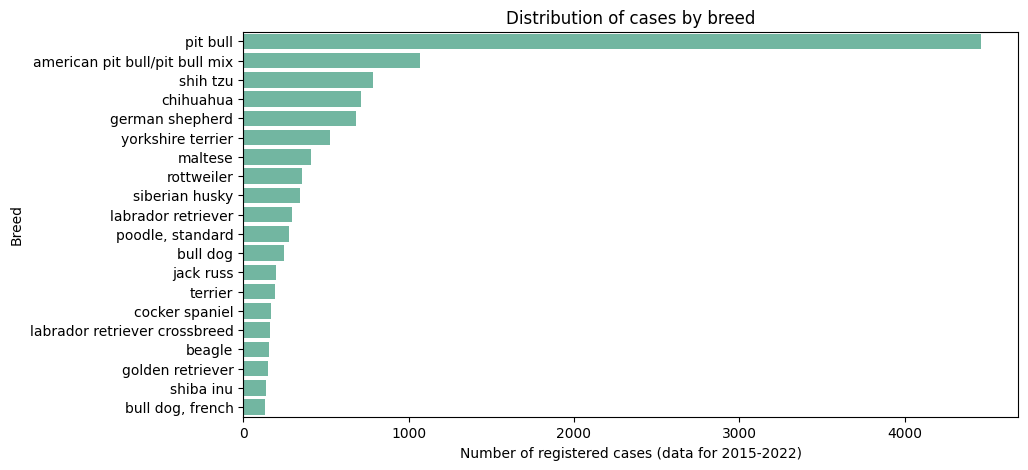

In [32]:
#creating plot
plt.figure(figsize=(10, 5))
sns.barplot(data=breed_top, x='count', y='breed', errorbar=None)

#assigning axes and titles
plt.title('Distribution of cases by breed')
plt.xlabel('Number of registered cases (data for 2015-2022)') 
plt.ylabel('Breed');

**Let's evaluate the distribution of cases by gender**

In [33]:
data['gender'].value_counts(normalize=True)*100 #counting unique values in a column and counting percentage

gender
U    47.728819
M    37.803658
F    14.467523
Name: proportion, dtype: float64

**Observations:**

* in 48% of cases the sex of the animal remained unknown
* in cases where the sex of the animal was indicated, males were found 2.64 times more often than females

#### Interim conclusion

We analyzed the `breed` and `gender` columns and made the following conclusions:

* in cases where the animal's gender was specified, males are encountered 2.64 times more often
* pit bulls lead in the number of cases by a fairly large margin (14% of all attacks)
* we found out that for a more accurate study of breed aggressiveness, the data in the column is too polluted with errors and duplicates, and we also do not have accurate information on the number of dogs of each breed in the city.

### Research Results

Progress of the study::

**`Data preprocessing:`**

* removed unnecessary columns and brought the names to a single spelling
* checked the dataset for missing data and filled it with suitable values
* checked the dataset for exact and partial duplicates, found that breed column contains raw data
* changed the data type in the 'date_of_bite' column to the appropriate one, and added additional columns with the month and year of the case.

**`Exploratory data analysis and the following conclusions:`**

* **The hypothesis that seasonality affects the number of attacks was confirmed.** In the winter months, on average, 34.5% fewer cases were recorded than in summer.
* Found out **the leading borough in terms of the number of cases is Staten Island**, where there are an average of 540 attacks per million residents per year.
* In cases where the animal's gender was specified, **males are 2.64 times more common than females**
* **Pit bull terriers lead in the number of attacks by a fairly large margin (14% of all attacks)**, but we cannot draw more detailed conclusions from the available data

The publication of the results of the analysis can help raise awareness among people about the risks associated with dog bites and encourage them to treat animals more responsibly.